# CPSC 330 Lecture 8

#### Lecture plan

- Announcements
- Logistic regression intro (5 min)
- `CountVectorizer` and feature preprocessing pitfalls (25 min)
- Break (5 min)
- Logistic regression: `predict_proba` (10 min)
- Logistic regression: coefficients and interpretation (10 min)
- Logistic regression with continuous features (10 min)
- True/False questions (15 min)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

from plot_classifier import plot_classifier

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
            
    """    
    print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
    print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))

## Announcements

- Add-Drop has passed - welcome to the course!
- Please fill out the new survey on [Canvas](https://canvas.ubc.ca/courses/36014) by Thursday.
- hw1 grades posted, hw2 deadlines passed, hw3 posted.
- The homework deadline has been moved to Sunday at 6pm.
- New requirement for working with partners: a short statement about who did what.
- Some (all?) of the tutorial sections are trying out a "help session" format - please provide feedback to me or the TAs!

## Logistic regression intro (5 min)

#### Motivating example 

- Sentiment analysis: predict the sentiment of text, such as a movie review.
- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *well* for 👍 and *boring* for 👎)

<blockquote> 
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p> 
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p> 
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

#### Intuition behind a linear classifier

- Learn coefficients (weights) associated with different features

<img src='img/words_coeff.png' width="300" height="300" />

- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
    <p>It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>. </p> 
</blockquote>

#### Linear classifier 

- $score(x_i) = $ coefficient(*boring*) + coefficient(*excellent*) + coefficient(*flawless*) = $-1.40 + 1.93 + 1.43 = 1.96$
- Since $score(x_i) = 1.96 > 0$, predict the review as positive 👍. 
- Components of a linear model
    - input features ($x_1, \dots, x_d$)
    - coefficients (weights) ($w_1, \dots, w_d$)
    - bias or intercept ($b$ or $w_0$)

#### Logistic regression

In particular, we will focus on 
- use `fit`, `predict`, `predict_proba`
- use `coef_` to interpret the model weights 


## `CountVectorizer` and feature preprocessing pitfalls (25 min)

#### Let's train it on a dataset

I have downloaded the [IMDB movie review dataset](https://www.kaggle.com/utathya/imdb-review-dataset) from Kaggle. You should be able to download it as well. I did not push it to the home repo because it is large and because I don't have permission to redistribute it.

In [123]:
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)
imdb_df

,type,review,label,file
12438,test,As Jennifer Denuccio used to say on Square Peg...,neg,9946_2.txt
5705,test,"With Knightly and O'Tool as the leads, this fi...",neg,3886_3.txt
11675,test,"Take a bad script, some lousy acting and throw...",neg,9259_1.txt
9824,test,Strange things happen to Americans Will (Greg ...,neg,7593_3.txt
22581,test,"Sometimes, you're up late at night flipping th...",pos,7824_7.txt
...,...,...,...,...
31555,train,With a cast of stalwart British character acto...,neg,4650_2.txt
36478,train,There's a lot of movies that have set release ...,neg,9081_1.txt
35878,train,Welcome to movie 17 on the chilling classics 5...,neg,8541_1.txt
16040,test,"This is a forgotten classic of a film, and Har...",pos,1937_10.txt


In [124]:
imdb_df.shape

(10000, 4)

- Above, we used some key words in a review to decide how to classify it. 
- But here, we just have raw text:

In [125]:
imdb_df.loc[1,"review"]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

We need a way to transform this raw text into use usual tabular format, where each column is a feature... hmm... 🤔

<br><br><br><br>

How about this: each word is a feature (column), and we check whether the word is present or absent in the review 💡

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

Make a CountVectorizer object:

In [127]:
vec = CountVectorizer(binary=True)

Note `binary=True` - that means just check whether a word is present (1) or absent (0), instead of counting the number of occurrences of the word.

Call `fit`:

In [128]:
vec.fit(imdb_df["review"]) 

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

For feature preprocessing objects, called _transformers_, we use `transform` instead of `predict` (indeed, it's not a prediction):

In [129]:
X = vec.transform(imdb_df["review"])

In [14]:
X[1].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

Hmm, is it only zeros for this first review?

In [15]:
X.shape

(10000, 52863)

That's a lot of columns!

In [17]:
vec.get_feature_names()[:20]

['00',
 '000',
 '001',
 '007',
 '0093638',
 '00pm',
 '00s',
 '01',
 '02',
 '03',
 '04',
 '041',
 '05',
 '06',
 '0615',
 '06th',
 '07',
 '08',
 '089',
 '0and']

- Ok, this seems like a lot of useless "words".
- We can use some hyperparameters of the `CountVectorizer` to just take more common words.
- Note: later in the course, after reading week, we will explore this more in terms of removing useless words, etc.
  - For now we'll just focus on subsetting the features.

In [18]:
vec = CountVectorizer(min_df=50, binary=True) # words that appear at least n times

vec.fit(imdb_df["review"]) 

X = vec.transform(imdb_df["review"])

In [19]:
X.shape

(10000, 3243)

We can also explicitly ask for the top $n$ words:

In [139]:
vec = CountVectorizer(max_features=1000, binary=True) # max n columns

vec.fit(imdb_df["review"]) 

X = vec.transform(imdb_df["review"])

In [140]:
X.shape

(10000, 1000)

In [141]:
data_df = pd.DataFrame(data=X.toarray(), columns=vec.get_feature_names())
data_df

,10,20,30,80,able,about,above,absolutely,across,act,...,wrong,year,years,yes,yet,york,you,young,your,yourself
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,1,0
9997,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Ok, now we split the data...

In [22]:
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X, 
                                                                        imdb_df['label'], 
                                                                        test_size = 0.20, 
                                                                        random_state = 12)

Ok, this seems reasonable. Are we all good?

<br><br><br><br><br><br>

# NO!!

- We violated the Golden Rule!
- I told you it could be sneaky.
- What happened? Well, the test data influenced how we preprocessed the training data:
  - We used it to determine which words were the top words.
  - In fact, some of our features might be words that don't even appear in the training set!!
  - Thus, **the test error is no longer an accurate measure of how our model generalizes to unsees data**.
- So, we need to start over...

In [23]:
# Just to be safe
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)

In [24]:
# STEP 1
X_train_imdb_raw, X_test_imdb_raw, y_train_imdb, y_test_imdb = train_test_split(imdb_df['review'], 
                                                                                imdb_df['label'], 
                                                                                test_size = 0.20, 
                                                                                random_state = 12)

In [44]:
vec = CountVectorizer(min_df=50)

In [45]:
vec.fit(X_train_imdb_raw);

In [46]:
X_train_imdb = vec.transform(X_train_imdb_raw)

In [47]:
vec.fit(X_test_imdb_raw);

In [48]:
X_test_imdb = vec.transform(X_test_imdb_raw);

Now surely we're all good, right?

<br><br><br><br><br><br>

# NOPE

In [49]:
dt = DecisionTreeClassifier()

In [50]:
dt.fit(X_train_imdb, y_train_imdb);

In [51]:
dt.predict(X_test_imdb)

ValueError: Number of features of the model must match the input. Model n_features is 2699 and input n_features is 835 

In [33]:
X_train_imdb.shape

(8000, 2699)

In [34]:
X_test_imdb.shape

(2000, 835)

- What happened here?
- We fit the transformer on the training data, and transformed.
- Then we fit the transformer on the test data, and transformed.
- Now our data set makes no sense - we have a different number of columns in our train/test set!
- So, for example, the decision tree will split on a word "amazing", which is feature 2000, but then when we predict, we don't even have that feature!
- This is not a Golden Rule issue, it's just a preprocessing failure.
  - But note how the Golden Rule issue is harder to catch, because there's no Python error message.

In fact, if we had used `max_features` instead of `min_df` we wouldn't have even gotten a Python error message! See below:

In [112]:
vec = CountVectorizer(max_features=1000)

In [113]:
vec.fit(X_train_imdb_raw);

In [114]:
vec.get_feature_names()[:10]

['10',
 '20',
 '30',
 '80',
 'able',
 'about',
 'above',
 'absolutely',
 'across',
 'act']

In [115]:
X_train_imdb = vec.transform(X_train_imdb_raw)

In [116]:
vec.fit(X_test_imdb_raw);

In [117]:
vec.get_feature_names()[:10]

['10',
 '20',
 'able',
 'about',
 'above',
 'absolutely',
 'across',
 'act',
 'acted',
 'acting']

In [118]:
X_test_imdb = vec.transform(X_test_imdb_raw);

In [119]:
dt = DecisionTreeClassifier()

In [120]:
dt.fit(X_train_imdb, y_train_imdb);

In [121]:
dt.predict(X_test_imdb)

array(['neg', 'pos', 'pos', ..., 'neg', 'neg', 'neg'], dtype=object)

- Note: no error message.
- The problem is that the coefficients correspond to the **order** of the features, so the results will be completely invalid.

#### Attempt 3 (I promise it will be OK this time)

In [33]:
# Just to be safe
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)

In [34]:
# STEP 1
X_train_imdb_raw, X_test_imdb_raw, y_train_imdb, y_test_imdb = train_test_split(imdb_df['review'], 
                                                                                imdb_df['label'], 
                                                                                test_size = 0.20, 
                                                                                random_state = 12)

In [37]:
vec = CountVectorizer(min_df=50, binary=True)

I am setting `binary=True` which gives just 1 or 0 for the features (word is present or absent); by default it _counts_ the number of occurrences of the word. I am using binary to be consistent with the motivating example at the start of class.

In [38]:
vec.fit(X_train_imdb_raw);

In [39]:
X_train_imdb = vec.transform(X_train_imdb_raw)

We do not want this next line!!!

In [40]:
# vec.fit(X_test_imdb_raw);

We transform the test data with the transformer _fit on the training data_!!

In [41]:
X_test_imdb = vec.transform(X_test_imdb_raw);

Ok, let's give this a try:

In [58]:
dt = DecisionTreeClassifier()
dt.fit(X_train_imdb, y_train_imdb);

In [59]:
show_scores(dt, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb)

Training error:   0.00
Validation error: 0.32


## Break (5 min)

If you haven't already, please take a moment to fill out the new survey on [Canvas](https://canvas.ubc.ca/courses/36014).

## Logistic regression: `predict_proba` (10 min)

In [77]:
lr = LogisticRegression()
lr.fit(X_train_imdb, y_train_imdb)
show_scores(lr, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb) 

/Users/mgelbart/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training error:   0.02
Validation error: 0.16


Cool, we got a better validation error this way!

#### Predicting probabilities

- Logistic regression seems to do fairly well on this task.
- Furthermore, we have a new and useful method, `predict_proba`.
- `predict` returns the class with the highest probability.
- Can we find the reviews where our classifier is most confident or least confident?
- How about reviews where the classifier is not very confident? 

In [79]:
# predict_proba
probs = lr.predict_proba(X_test_imdb)
probs

array([[8.59914292e-01, 1.40085708e-01],
       [5.27906505e-01, 4.72093495e-01],
       [4.26982364e-04, 9.99573018e-01],
       ...,
       [3.22773733e-03, 9.96772263e-01],
       [9.99998415e-01, 1.58464586e-06],
       [9.99949271e-01, 5.07293877e-05]])

In [80]:
probs.shape

(2000, 2)

- It gives two columns, the probability of class 0 and the probability of class 1. 
- We only really care about one of them, since they add to 1. Let's take the second column:

In [81]:
lr.predict_proba(X_test_imdb)[:,1]

array([1.40085708e-01, 4.72093495e-01, 9.99573018e-01, ...,
       9.96772263e-01, 1.58464586e-06, 5.07293877e-05])

What's the most positive and most negative review according to our classifier?  


In [82]:
np.max(lr.predict_proba(X_test_imdb)[:,1])

0.9999999999915541

Wow! Let's find that review:

In [83]:
most_positive_ind = np.argmax(lr.predict_proba(X_test_imdb)[:,1])
most_positive_ind

1189

In [84]:
print(X_test_imdb_raw.iloc[most_positive_ind])

Sri Lanka... not a country I've ever given much thought to, I have to admit. I didn't even know it was near India, let alone that there has been a bloody civil war going on there since 1983. It seems that the rebels of the Tamil minority have been in an ongoing conflict with the military regime that runs the country for many years, causing many deaths and widespread suffering on the island.<br /><br />Mani Ratman's latest film, A PECK ON THE CHEEK, tells the story of a young girl named Amudha, who is separated from her Sri Lankan parents by the war and raised by a young Indian couple. Amudha is a bright and mischievous girl, whose life is turned upside down when her parents tell her that she was adopted as a child. Although her adopted parents love her as much as could be, and have raised her without prejudice along with their biological children, Amudha cannot help but want to learn more about her biological family.<br /><br />Mani Ratman is probably best known for his 1998 film DIL S

Most negative review:

In [85]:
most_negative_ind = np.argmax(lr.predict_proba(X_test_imdb)[:,0])
most_negative_ind

315

In [86]:
print(X_test_imdb_raw.iloc[most_negative_ind])

Serum starts as Eddie (Derek Phillips) is delighted to learn he has been accepted into medical school to carry on the family tradition of becoming an MD like his father Richard (Dennis O'Neill) & his uncle Eddie (David H. Hickey), however his joy could be short lived as Eddie is involved in an accident & is run over by a car. Taken to the nearest hospital it doesn't look good for poor Eddie so his uncle Eddie convinces his brother Richard to let him save Eddie with the serum he has developed, a serum which will give the recipient the power to self heal any sort of wound or illness. Desperate for his boy to live Richard agrees but the procedure has unwanted side effects like turning Eddie into a brain eating zombie which is just not a good thing...<br /><br />Executive produced, written & directed by Steve Franke I'll be perfectly frank myself & say Serum is awful, Serum is one of those no budget horror films which tries to rip-off other any number of other's & ends up being slightly mo

## Logistic regression: coefficients and interpretation (10 min)

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- What features are most useful for prediction? What words are swaying it positive or negative?

#### Let's find the most informative words for positive and negative reviews 

- The information you need is exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 
- The vocabulary (mapping from feature indices to actual words) can be obtained as follows: 

In [87]:
lr.coef_

array([[-0.54442233,  0.56953794, -0.07879   , ..., -0.23357516,
        -0.43565269, -0.30189978]])

In [88]:
# Get features (words in our case)
vocab = vec.get_feature_names()
vocab[:30]

['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '1950',
 '1970',
 '20',
 '2001',
 '2005',
 '25',
 '30',
 '40',
 '50',
 '60',
 '70',
 '70s',
 '80',
 '80s',
 '90',
 'abandoned',
 'ability',
 'able',
 'about',
 'above',
 'absolute',
 'absolutely']

In [89]:
weights = lr.coef_.ravel()
weights[:30]

array([-0.54442233,  0.56953794, -0.07879   , -0.26744046,  0.23499243,
        0.01400122,  0.13464958, -0.44682037,  0.24512197, -0.74487161,
       -0.13465905,  0.01601938, -0.1729897 ,  0.25179987, -0.18391194,
        0.11441062, -0.1438524 ,  0.20293821,  0.18569506, -0.03764818,
       -0.12660893, -0.16668699, -0.41461795,  0.52860547, -0.14569557,
        0.22471882, -0.10588138,  0.14516093,  0.41565422,  0.09467749])

In [90]:
words_weights_df = pd.DataFrame(data=weights, index=vocab, columns=['Weight'])
words_weights_df

,Weight
000,-0.544422
10,0.569538
100,-0.078790
11,-0.267440
12,0.234992
...,...
yourself,0.067347
youth,0.108680
zero,-0.233575
zombie,-0.435653


In [91]:
words_weights_df.sort_values(by="Weight", ascending=False)

,Weight
masterpiece,1.716159
noir,1.637397
perfect,1.633423
solid,1.605331
exceptional,1.572932
...,...
forgettable,-2.052239
terrible,-2.108603
awful,-2.198328
waste,-2.530349


- These coefficients make sense!
- Let's use this to explore one of the test cases:

In [92]:
ex = 5
lr.predict_proba(X_test_imdb)[ex,1]

0.0018543169525522983

In [93]:
X_test_imdb_raw.iloc[ex]

"Its plain to see why the makers of Scary Movie found it so easy to spoof these 'teen slasher' movies. They are so unbelievably formulaic. And if Valentine had been released a year or so earlier, I'm sure they would have been spoofing this film too - that's if they found any actual original material to distinguish it from the Screams, I know what you did last summers, and Urban Legends.<br /><br />Valentine offers nothing new to this genre, except a better than usual ending which, of course, leaves lots of room for the inevitable sequel. As always, a masked psychotic killer stalks a bunch of beautiful young women, killing the main character's friends, one by one, in typically over the top style. Lots of T&A on display, no character development, bad acting, and overly elaborate bloodshed.<br /><br />The thing I can't stand about these kind of movies is that they pass themselves off as 'who done its?'. The thing is that they aren't because the motive is only revealed once the killer has 

In [96]:
words_in_ex = X_test_imdb[ex].toarray().ravel().astype(bool)
words_in_ex

array([False, False, False, ..., False, False, False])

How many of the words are in this review?

In [98]:
np.sum(words_in_ex)

183

In [97]:
np.array(vocab)[words_in_ex]

array(['about', 'acting', 'actual', 'after', 'alive', 'all', 'almost',
       'along', 'always', 'an', 'and', 'another', 'any', 'anybody',
       'anyway', 'are', 'aren', 'as', 'at', 'bad', 'beautiful', 'because',
       'been', 'being', 'better', 'br', 'bunch', 'but', 'by', 'can',
       'character', 'clear', 'coming', 'count', 'course', 'demons',
       'development', 'did', 'didn', 'display', 'doesn', 'dog', 'don',
       'done', 'during', 'earlier', 'easy', 'ending', 'escape',
       'everybody', 'except', 'father', 'film', 'followed', 'for',
       'formula', 'found', 'friend', 'friends', 'from', 'genre', 'given',
       'good', 'had', 'hard', 'has', 'have', 'his', 'if', 'important',
       'in', 'instead', 'is', 'issue', 'it', 'its', 'killer', 'killing',
       'kills', 'kind', 'know', 'last', 'lead', 'leaves', 'left', 'lines',
       'lots', 'made', 'main', 'make', 'makers', 'making', 'manages',
       'material', 'may', 'more', 'mother', 'movie', 'movies', 'much',
       'murde

In [99]:
ex_df = pd.DataFrame(data=weights[words_in_ex], index=np.array(vocab)[words_in_ex], columns=['Weight'])
ex_df

,Weight
about,-0.105881
acting,-0.372368
actual,-0.158372
after,-0.138115
alive,0.025010
...,...
women,-0.336860
would,-0.219344
year,-0.021090
you,0.257461


In [100]:
ex_df.sum()

Weight   -6.702551
dtype: float64

- As we can see, the sum is negative, so we predicted that it's a negative review.
- Also, the more negative this value is, the closer to 0 the predicted probability would be. 
  - If this value were exactly 0, the predicted probability would be exactly 0.5.

#### Why people use logistic regression?  

- Logistic regression is extremely popular!
- Fast training and testing.
  - Training on huge datasets.
- Interpretability
  - Weights are how much a given feature changes the prediction and in what direction.

## Logistic regression with continuous features (5 min)

In [17]:
cities_df = pd.read_csv('data/cities_USA.csv', index_col=0)

In [18]:
cities_train, cities_test = train_test_split(cities_df, random_state=1)

In [19]:
X_train = cities_train.drop(columns=['vote'])
y_train = cities_train['vote']

# X_test  = df_valid_shuffle.drop(columns=['vote'])
# y_test  = df_valid_shuffle['vote']

In [20]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

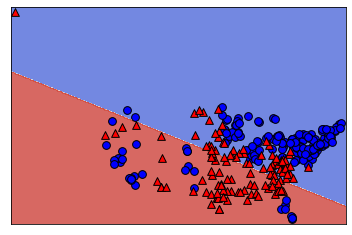

In [21]:
plot_classifier(X_train, y_train, lr);

- There are still some coefficients/weights being multiplied by the features.
- A linear classifier "slices the space in half" with a "hyperplane" (with 2 features, this is just a line).

Let's look at the predicted probabilties:

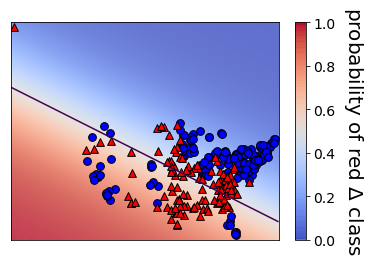

In [15]:
plot_classifier(X_train, y_train, lr, proba=True);

An important hyperparameter: `C` (default is `C=1.0`).

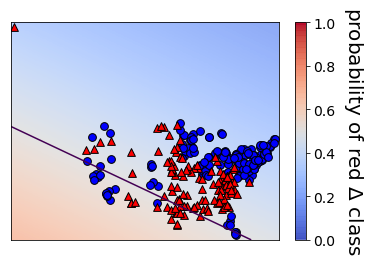

In [24]:
lr = LogisticRegression(C=.0001)
lr.fit(X_train, y_train);
plot_classifier(X_train, y_train, lr, proba=True);

- Smaller `C` leads to less confident predictions (probabilties closer to 0.5).
- In general, we say smaller `C` leads to a less complex model (like a shallower decision tree).
  - Complex models are really a larger `C` in conjunction with lots of features.
  - Here we only have 2 features.

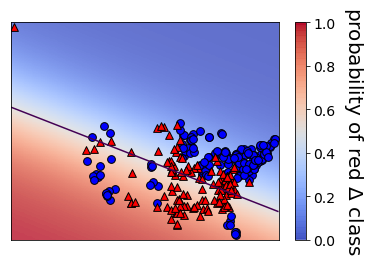

In [25]:
lr = LogisticRegression(C=1000)
lr.fit(X_train, y_train);
plot_classifier(X_train, y_train, lr, proba=True);

In [42]:
lr = LogisticRegression()
lr.fit(X_train_imdb, y_train_imdb)
show_scores(lr, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb) 

Training error:   0.02
Validation error: 0.16


In [43]:
lr = LogisticRegression(C = 10000)
lr.fit(X_train_imdb, y_train_imdb)
show_scores(lr, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb) 

Training error:   0.00
Validation error: 0.19


In [44]:
lr = LogisticRegression(C = 0.01)
lr.fit(X_train_imdb, y_train_imdb)
show_scores(lr, X_train_imdb, y_train_imdb, X_test_imdb, y_test_imdb) 

Training error:   0.11
Validation error: 0.14


## True/False questions --> Piazza

1. With `CountVectorizer`, we should be `fit` on the training data, and `transform` on both the train/test data.
2. `predict` returns the positive class if the predicted probability of the positive class is greater than 0.5.
3. Logistic regression overfits less than decision trees.
4. With logistic regression, we learn one weight per training example.

## Next class

- Dealing with categorical features.
- Logistic regression with continuous features.
- Another classifier: SVMs
- Another classifier: random forests
- Ensembles